In [2]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit
from xhistogram.xarray import histogram
from collections import OrderedDict

from dask.distributed import Client

%matplotlib inline

In [3]:
client = Client(n_workers=8)
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34405/status,
Dashboard: /proxy/34405/status,Workers: 8
Total threads: 8,Total memory: 60.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34243,Workers: 8
Dashboard: /proxy/34405/status,Total threads: 8
Started: Just now,Total memory: 60.00 GiB
Comm: tcp://127.0.0.1:42963,Total threads: 1
Dashboard: /proxy/37553/status,Memory: 7.50 GiB
Nanny: tcp://127.0.0.1:35555,


In [4]:
### Generate new database

db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'

session = cc.database.create_session(db)

In [17]:
yr_beg = '2400-01-01'
yr_end = '2449-12-31'

var = 'mld'
frequency = '1 monthly'

mld_cont = xr.open_mfdataset(paths='/scratch/e14/mp2135/access-om2/archive/1deg_jra55_ryf_cont/output1*/ocean/ocean-2d-mld*', 
                             combine='by_coords').mld.sel(time=slice(yr_beg, yr_end)).groupby('time.year').mean(dim='time').load()
mld_cool = xr.open_mfdataset(paths='/scratch/e14/mp2135/access-om2/archive/1deg_jra55_ryf_cool_x1/output1*/ocean/ocean-2d-mld*', 
                             combine='by_coords').mld.sel(time=slice(yr_beg, yr_end)).groupby('time.year').mean(dim='time').load()
mld_warm = xr.open_mfdataset(paths='/scratch/e14/mp2135/access-om2/archive/1deg_jra55_ryf_warm_x1/output1*/ocean/ocean-2d-mld*', 
                             combine='by_coords').mld.sel(time=slice(yr_beg, yr_end)).groupby('time.year').mean(dim='time').load()

In [19]:
def area_weighted_ave(tracer, expt):
    lat_lower = float(tracer['yt_ocean'][0]) # so that this function will work when we have hemipsherically-decomposed
    lat_upper = float(tracer['yt_ocean'][-1])
    area_t = cc.querying.getvar(expt, 'area_t', session, n=1).sel(yt_ocean=slice(lat_lower, lat_upper)).load() # area of cells
    area_total = area_t.sum(dim=('xt_ocean', 'yt_ocean')) # total area of ocean

    return (area_t * tracer).sum(dim=('xt_ocean', 'yt_ocean')) / area_total

def NH_decomp(array):
    return array.sel(yt_ocean = slice(0, None))

def SH_decomp(array):
    return array.sel(yt_ocean = slice(None, 0))

# Global means:

expt = '1deg_jra55_ryf_cont'
tracer = mld_cont
mld_cont_ave = area_weighted_ave(tracer, expt)
mld_cont_ave_SH = area_weighted_ave(SH_decomp(tracer), expt)
mld_cont_ave_NH = area_weighted_ave(NH_decomp(tracer), expt)

expt = '1deg_jra55_ryf_cool_x1'
tracer = mld_cool
mld_coolx1_ave = area_weighted_ave(tracer, expt)
mld_coolx1_ave_SH = area_weighted_ave(SH_decomp(tracer), expt)
mld_coolx1_ave_NH = area_weighted_ave(NH_decomp(tracer), expt)

expt = '1deg_jra55_ryf_warm_x1'
tracer = mld_warm
mld_warmx1_ave = area_weighted_ave(tracer, expt)
mld_warmx1_ave_SH = area_weighted_ave(SH_decomp(tracer), expt)
mld_warmx1_ave_NH = area_weighted_ave(NH_decomp(tracer), expt)

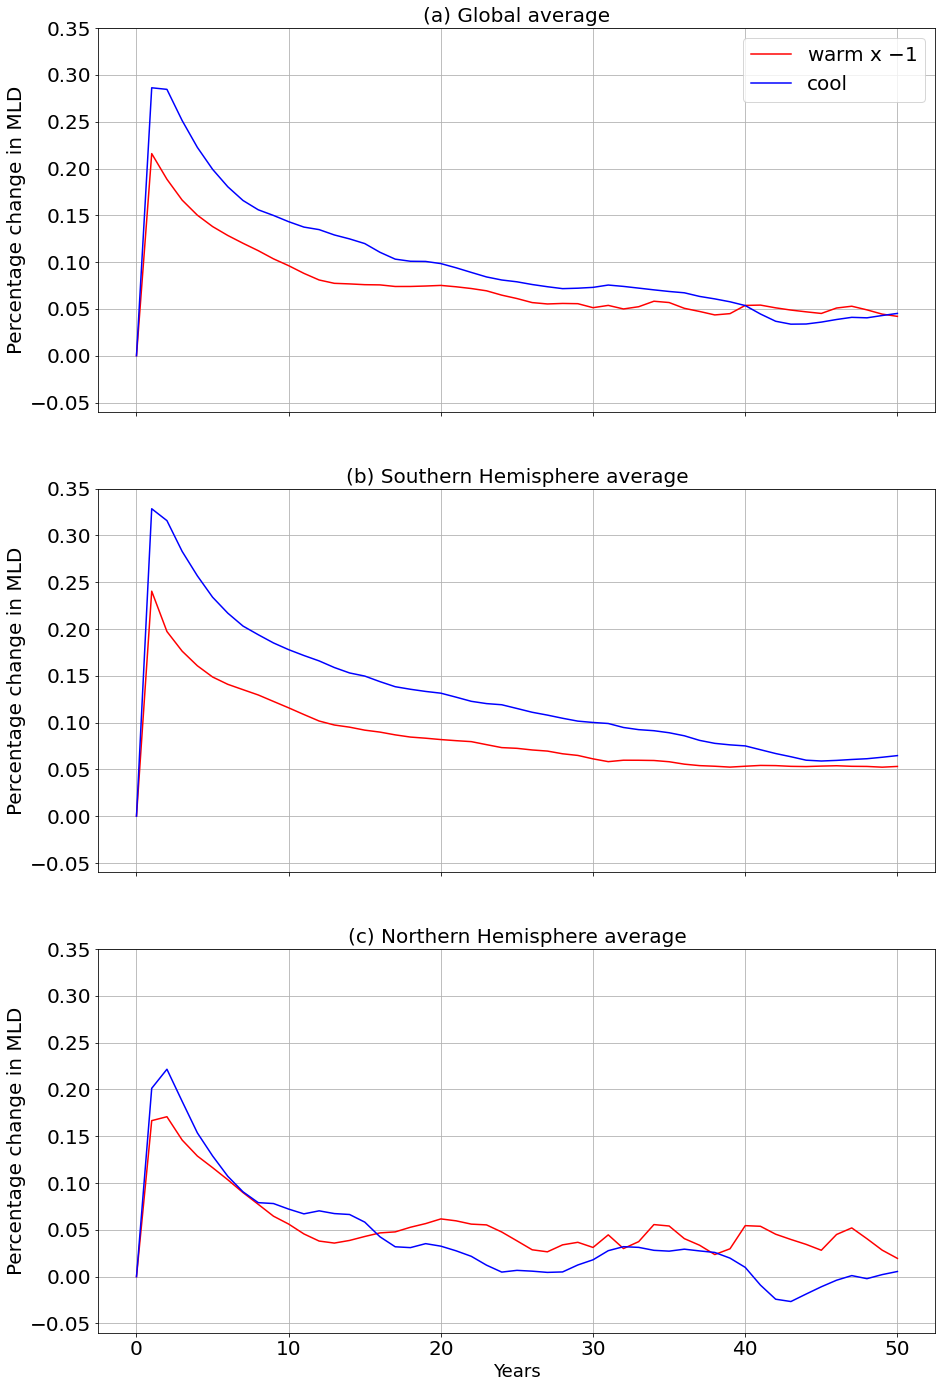

In [25]:
fig, axs = plt.subplots(ncols=1, nrows=3, figsize = (15,24), sharex=True)

def mld_plot(cont, cool, warm, title):
    zero = xr.DataArray(data=[0], dims='year', coords={"year": [2399]})
    mld_warm_anom = xr.concat([zero, (warm - cont) / cont], dim='year')
    mld_cool_anom = xr.concat([zero, (cool - cont) / cont], dim='year')
    
    # (-1 * mld_warm_anom).plot(ax = ax, label='warm x $-1$', color = 'r')
    # mld_cool_anom.plot(ax = ax, label='cool', color = 'b')
    
    ax.plot(np.linspace(0,50,warm.year.shape[0]+1), -1 * mld_warm_anom, label='warm x $-1$', color = 'r')
    ax.plot(np.linspace(0,50,cool.year.shape[0]+1), mld_cool_anom, label='cool', color = 'b')
    
    fontsize=20
    
    ax.set_title(title, fontsize=fontsize)
    ax.set_ylabel('Percentage change in MLD', fontsize=fontsize)
    ax.set_xlabel('', fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)
    ax.grid()
    ax.set_ylim(-0.06, 0.35)

ax = axs[0]
mld_plot(mld_cont_ave, mld_coolx1_ave, mld_warmx1_ave, '(a) Global average')
ax.legend(fontsize=20)


ax = axs[1]
mld_plot(mld_cont_ave_SH, mld_coolx1_ave_SH, mld_warmx1_ave_SH, '(b) Southern Hemisphere average')

ax = axs[2]
mld_plot(mld_cont_ave_NH, mld_coolx1_ave_NH, mld_warmx1_ave_NH, '(c) Northern Hemisphere average')
ax.set_xlabel('Years', fontsize=18)

plt.savefig('Fig6.pdf', bbox_inches='tight', dpi=300)